In [1]:
import numpy as np
from tqdm import tqdm

import rdkit
from rdkit import Chem
from rdkit.Chem import DataStructs

from utils import fingerprint, similarities

### read in data

suppl = Chem.SDMolSupplier('data/50ActivityClasses_10kCompounds.sdf')
mols = [mol for mol in tqdm(suppl)]
targs = [mol.GetProp('Target') for mol in mols]

### fingerprints and similarities

fps = [fingerprint(mol) for mol in tqdm(mols)]
sim_mat = np.array([similarities(fp, fps) for fp in tqdm(fps)])

RDKit WARNING: [00:29:27] Enabling RDKit 2019.09.3 jupyter extensions
100%|██████████| 10000/10000 [00:14<00:00, 691.87it/s]


In [5]:
### hists of similarities

n = len(mols)

t = np.array(targs).reshape(-1, 1)
sim_bio = t == t.T
triu = (np.triu(np.ones((n, n))) * (1 - np.eye(n))).astype(bool)
same = (sim_bio * triu).astype(bool)
diff = ((1 - sim_bio) * triu).astype(bool)

sims = sim_mat[triu]
sims_same = sim_mat[same]
sims_diff = sim_mat[diff]

In [6]:
print(sims.shape)
print(sims_same.shape)
print(sims_diff.shape)

(49995000,)
(995000,)
(49000000,)


In [18]:
sample_size = int(1e3)
# sims_sampled      = np.random.choice(sims,      size=int(5e4))
sims_sampled_same = np.random.choice(sims_same, size=int(1e4))
sims_sampled_diff = np.random.choice(sims_diff, size=int(1e4))

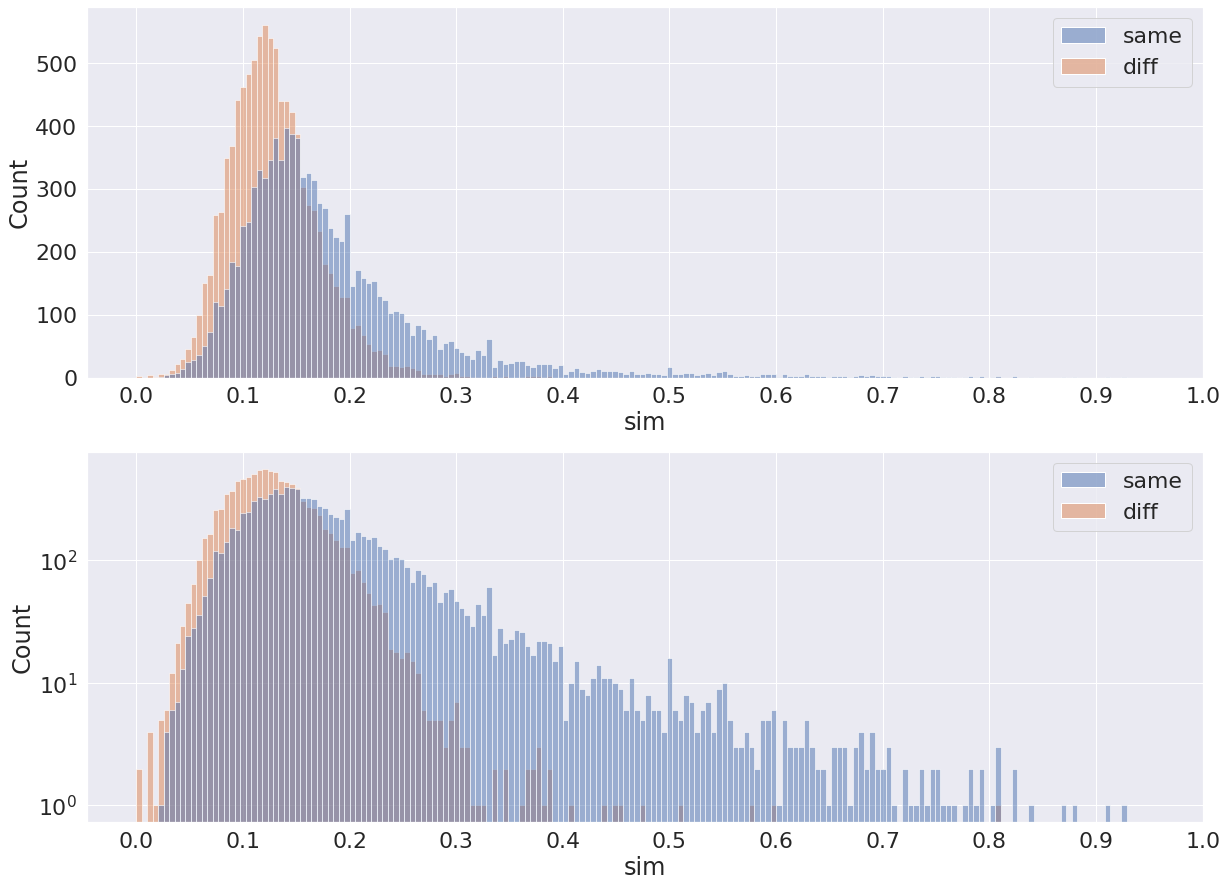

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'same': sims_sampled_same,
    'diff': sims_sampled_diff
})

fig, axs = plt.subplots(2, 1 , figsize=(20,15))
sns.set(font_scale=2)

ax = sns.histplot(data=df, stat='count', ax=axs[0])
ax.set(xlabel='sim', xticks=np.arange(0, 1.1, 0.1))

ax = sns.histplot(data=df, stat='count', ax=axs[1])
ax.set(xlabel='sim', xticks=np.arange(0, 1.1, 0.1), yscale="log")

plt.show()

In [99]:
### umap visualization

import umap

mapper = umap.UMAP(metric='precomputed', n_neighbors=50).fit(1 - sim_mat)

hover_data = pd.DataFrame({
    'index': np.arange(n),
    'label': targs
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=targs, hover_data=hover_data, point_size=2)
umap.plot.show(p)

/home/yutxie/miniconda3/envs/csa/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Loading BokehJS ...

In [136]:
### random subsets

subset_sizes = range(10, 101, 10)
n_run_per_size = 1000

n_classes = {
    sz : [] for sz in subset_sizes
}
ntargs = np.array(targs)
for size in subset_sizes:
    for run in range(n_run_per_size):
        ind = np.random.choice(n, size=size)
        n_classes[size].append(np.unique(ntargs[ind]).shape[0])

<AxesSubplot:xlabel='n_class', ylabel='Count'>

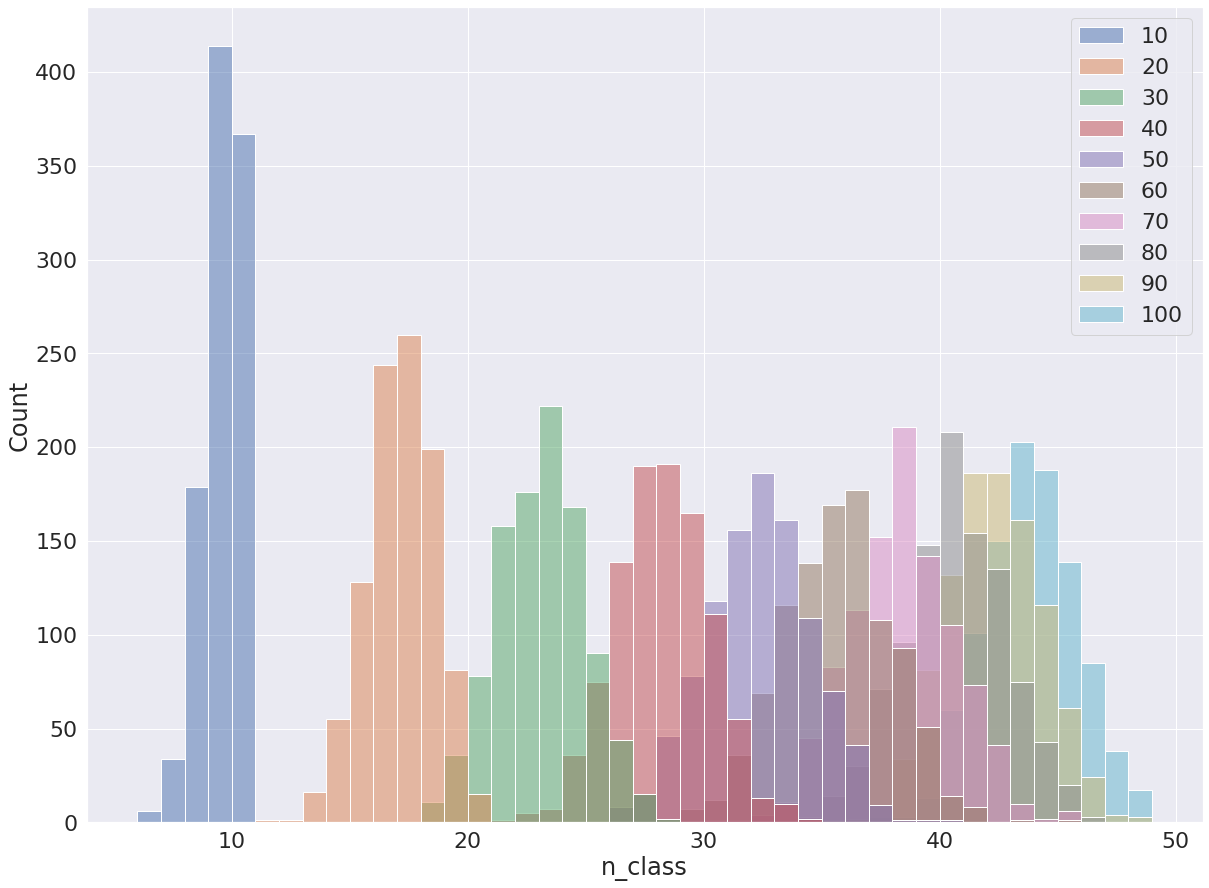

In [137]:
df = pd.DataFrame(n_classes)

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)

ax = sns.histplot(data=df, stat='count', binwidth=1)
ax.set(xlabel='n_class')
ax

<AxesSubplot:>

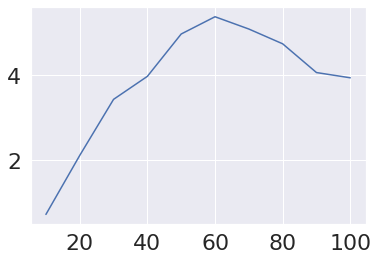

In [139]:
# print([(sz, np.var(n_list)) for sz, n_list in n_classes.items()])
sns.lineplot(x=n_classes.keys(), y=[np.var(v) for v in n_classes.values()])

In [140]:
sz = 60
n_runs = 10
sims_list = []
for run in tqdm(range(10)):
    ind = np.random.choice(n, size=sz)
    fps_ = [fps[i] for i in ind]
    sims = np.array([similarities(fp, fps_) for fp in fps_])
    
    triu = (np.triu(np.ones((sz, sz))) * (1 - np.eye(sz))).astype(bool)
    sims_list.append(sims[triu])

100%|██████████| 10/10 [00:00<00:00, 72.19it/s]


<AxesSubplot:xlabel='sim', ylabel='Count'>

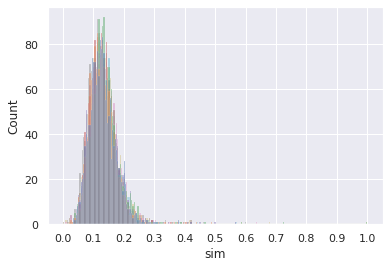

In [145]:
# plt.figure(figsize=(20, 15))
sns.set(font_scale=1)

ax = sns.histplot(data=sims_list, stat='count', legend=False)
ax.set(xlabel='sim', xticks=np.arange(0, 1.1, 0.1))
ax